<a href="https://colab.research.google.com/github/Whyshnavi/ML_Projects/blob/main/CNN_LSTM_IMAGE_CAPTIONING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rouge-score  # Install the rouge-score package

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=704dc0d3edbd424f775a782dc309f32e5ead09a82b4f18a10618a0fb1cb960e1
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Conv2D, MaxPooling2D, BatchNormalization
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import nltk
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
import pandas as pd

In [ ]:
# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
project_path = '/content/drive/MyDrive/DEEPLEARNING'
txt_cap_path = f"{project_path}/captions.txt"
extract_folders = f"{project_path}/Images"
pickle_path = f"{project_path}/fea_reuse.pkl"  # Save to Drive for persistence

In [ ]:
# Verify paths
if not os.path.exists(project_path):
    raise FileNotFoundError(f"Project directory {project_path} does not exist.")
if not os.path.exists(extract_folders):
    raise FileNotFoundError(f"Image directory {extract_folders} does not exist.")
if not os.path.exists(txt_cap_path):
    raise FileNotFoundError(f"Captions file {txt_cap_path} does not exist.")
print(f"Found {len(os.listdir(extract_folders))} images in {extract_folders}")
print(f"Captions file exists: {txt_cap_path}")

Found 8090 images in /content/drive/MyDrive/DEEPLEARNING/Images
Captions file exists: /content/drive/MyDrive/DEEPLEARNING/captions.txt


In [ ]:
# Custom CNN model from scratch
from tensorflow.keras.layers import GlobalAveragePooling2D # Import the missing layer

def custom_cnn_model():
    inputs = Input(shape=(224, 224, 3))

    # Initial Convolution
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 112x112

    # Residual Block 1
    x_shortcut = x
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x_shortcut = Conv2D(128, (1, 1), padding='same')(x_shortcut)  # Match dimensions
    x = add([x, x_shortcut])
    x = MaxPooling2D((2, 2))(x)  # 56x56

    # Residual Block 2
    x_shortcut = x
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x_shortcut = Conv2D(256, (1, 1), padding='same')(x_shortcut)
    x = add([x, x_shortcut])
    x = MaxPooling2D((2, 2))(x)  # 28x28

    # Residual Block 3
    x_shortcut = x
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x_shortcut = Conv2D(512, (1, 1), padding='same')(x_shortcut)
    x = add([x, x_shortcut])
    x = MaxPooling2D((2, 2))(x)  # 14x14

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Dense Layers
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)


     # Create the model
    model = Model(inputs=inputs, outputs=x) # Create the Model inside the function

    return model # Return the model object

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

model = custom_cnn_model()
img_path = '/content/drive/MyDrive/DEEPLEARNING/Images/109738916_236dc456ac.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
cnn_output = model.predict(image, verbose=0)
print(f"CNN Output Shape: {cnn_output.shape}")  # Should be (1, 4096)
print(f"CNN Output: {cnn_output[0][:5]}...")  # First 5 values of the feature vector

CNN Output Shape: (1, 4096)
CNN Output: [6.60837    0.83997023 0.         0.         3.637652  ]...


In [ ]:
# Feature extraction
def extract_features():
    model = custom_cnn_model()
    print(model.summary())
    features = {}
    directory = extract_folders
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        raise ValueError(f"No valid images found in {directory}. Please check the directory.")
    print(f"Processing {len(image_files)} images from {directory}")
    for img_name in tqdm(image_files):
        img_path = os.path.join(directory, img_name)
        try:
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)  # Shape: (1, 4096)
            image_id = img_name.split('.')[0]
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    if not features:
        raise ValueError("No features were extracted. Check image files and processing logic.")
    # Save features to Google Drive
    try:
        with open(pickle_path, 'wb') as f:
            pickle.dump(features, f)
        print(f"Features saved to {pickle_path}")
        print(f"Pickle file size: {os.path.getsize(pickle_path)} bytes")
    except Exception as e:
        print(f"Error saving pickle file: {e}")
        raise
    return features


In [ ]:
# Load or extract features with error handling
features = None
if os.path.exists(pickle_path) and os.path.getsize(pickle_path) > 0:
    try:
        with open(pickle_path, 'rb') as f:
            features = pickle.load(f)
        print(f"Loaded existing features from {pickle_path} with {len(features)} images")
    except (pickle.UnpicklingError, EOFError, Exception) as e:
        print(f"Error loading pickle file: {e}. Deleting and regenerating features...")
        if os.path.exists(pickle_path):
            os.remove(pickle_path)
            print(f"Deleted corrupted pickle file: {pickle_path}")
        features = extract_features()
else:
    print(f"No pickle file found at {pickle_path} or file is empty. Extracting features...")
    features = extract_features()

if features is None or len(features) == 0:
    raise ValueError("Feature extraction failed or no features were loaded.")

# Load captions
with open(txt_cap_path, 'r') as f:
    next(f)
    captions_doc = f.read()

Loaded existing features from /content/drive/MyDrive/DEEPLEARNING/fea_reuse.pkl with 8090 images


In [ ]:
# Create image-to-caption mapping
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption.split())
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
# Clean captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = ''.join([c for c in caption if c.isalpha() or c.isspace()])
            caption = ' '.join([word for word in caption.split() if len(word) > 1])
            caption = f'startseq {caption} endseq'
            captions[i] = caption

clean(mapping)

In [ ]:
# Collect all captions
all_captions = [caption for key in mapping for caption in mapping[key]]

In [ ]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
# Train-test split
image_ids = list(mapping.keys())
train_split = int(len(image_ids) * 0.80)
val_split = int(len(image_ids) * 0.90)
train = image_ids[:train_split]
val = image_ids[train_split:val_split]
test = image_ids[val_split:]
print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 6472
Validation size: 809
Test size: 810


In [ ]:
# Data generator wrapped in tf.data.Dataset
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def generator():
        X1, X2, y = [], [], []
        n = 0
        while True:
            for key in data_keys:
                n += 1
                if key not in features:
                    continue
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                        if n == batch_size:
                            yield (np.array(X1), np.array(X2)), np.array(y)
                            X1, X2, y = [], [], []
                            n = 0

    # Define output signature
    output_signature = (
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1: image features
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # X2: input sequences
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: one-hot encoded output
    )

    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    return dataset

In [ ]:
# Model creation
def build_4096_model(vocab_size, max_length, embedding_dim=256, lstm_units=256, learning_rate=1e-3):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(lstm_units, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    seq1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    seq2 = Dropout(0.4)(seq1)
    seq3 = LSTM(lstm_units, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)
    decoder1 = add([fe2, seq3])
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate))
    return model

In [ ]:
# Data generator wrapped in tf.data.Dataset
import tensorflow as tf # Import tensorflow at the beginning of the file

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def generator():
        X1, X2, y = [], [], []
        n = 0
        while True:
            for key in data_keys:
                n += 1
                if key not in features:
                    continue
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                        if n == batch_size:
                            yield (np.array(X1), np.array(X2)), np.array(y)
                            X1, X2, y = [], [], []
                            n = 0

    # Define output signature
    output_signature = (
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1: image features
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # X2: input sequences
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: one-hot encoded output
    )

    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    return dataset

In [ ]:
# Hyperparameter tuning
embedding_dims = [128, 256, 512]
lstm_units_list = [128, 256, 512]
learning_rates = [1e-3, 1e-4, 5e-4]
batch_sizes = [32, 64]
best_loss = float('inf')
best_config = None
full_history = {'loss': [], 'val_loss': []}

for emb_dim in embedding_dims:
    for lstm_unit in lstm_units_list:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTesting: Emb={emb_dim}, LSTM={lstm_unit}, LR={lr}, Batch={batch_size}")
                model = build_4096_model(vocab_size, max_length, emb_dim, lstm_unit, lr)
                steps = len(train) // batch_size
                val_steps = len(val) // batch_size
                generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
                val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)
                history = model.fit(
                    generator,
                    validation_data=val_generator,
                    epochs=1,
                    steps_per_epoch=steps,
                    validation_steps=val_steps,
                    verbose=1
                )
                val_loss = history.history['val_loss'][0]
                print(f"Validation Loss: {val_loss:.4f}")
                full_history['loss'].append(history.history['loss'][0])
                full_history['val_loss'].append(val_loss)
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_config = (emb_dim, lstm_unit, lr, batch_size)
                    model.save('/content/best_model.h5')

print("\nBest Config:")
print(f"Embedding: {best_config[0]}, LSTM: {best_config[1]}, LR: {best_config[2]}, Batch: {best_config[3]}")



Testing: Emb=128, LSTM=128, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 128s 594ms/step - loss: 6.1484 - val_loss: 5.0641


Validation Loss: 5.0641

Testing: Emb=128, LSTM=128, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 105s 967ms/step - loss: 6.3907 - val_loss: 5.5408
Validation Loss: 5.5408

Testing: Emb=128, LSTM=128, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 112s 519ms/step - loss: 7.0190 - val_loss: 5.8364
Validation Loss: 5.8364

Testing: Emb=128, LSTM=128, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 99s 894ms/step - loss: 7.4122 - val_loss: 5.8772
Validation Loss: 5.8772

Testing: Emb=128, LSTM=128, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 110s 508ms/step - loss: 6.3470 - val_loss: 5.4348
Validation Loss: 5.4348

Testing: Emb=128, LSTM=128, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 947ms/step - loss: 6.5650 - val_loss: 5.7092
Validation Loss: 5.7092

Testing: Emb=128, LSTM=256, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - loss: 5.9886 - val_loss: 4.8049


Validation Loss: 4.8049

Testing: Emb=128, LSTM=256, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - loss: 6.3731 - val_loss: 5.3468
Validation Loss: 5.3468

Testing: Emb=128, LSTM=256, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 204s 973ms/step - loss: 6.8723 - val_loss: 5.7575
Validation Loss: 5.7575

Testing: Emb=128, LSTM=256, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 7.2652 - val_loss: 5.8514
Validation Loss: 5.8514

Testing: Emb=128, LSTM=256, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 194s 921ms/step - loss: 6.2335 - val_loss: 5.2874
Validation Loss: 5.2874

Testing: Emb=128, LSTM=256, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - loss: 6.4523 - val_loss: 5.5696
Validation Loss: 5.5696

Testing: Emb=128, LSTM=512, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - loss: 5.9990 - val_loss: 4.6471


Validation Loss: 4.6471

Testing: Emb=128, LSTM=512, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - loss: 6.3357 - val_loss: 5.2422
Validation Loss: 5.2422

Testing: Emb=128, LSTM=512, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - loss: 6.6106 - val_loss: 5.6866
Validation Loss: 5.6866

Testing: Emb=128, LSTM=512, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 366s 4s/step - loss: 7.0194 - val_loss: 5.7912
Validation Loss: 5.7912

Testing: Emb=128, LSTM=512, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - loss: 6.1017 - val_loss: 5.1558
Validation Loss: 5.1558

Testing: Emb=128, LSTM=512, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - loss: 6.4058 - val_loss: 5.5115
Validation Loss: 5.5115

Testing: Emb=256, LSTM=128, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 96s 440ms/step - loss: 6.1487 - val_loss: 4.8795
Validation Loss: 4.8795

Testing: Emb=256, LSTM=128, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 8

Validation Loss: 4.5615

Testing: Emb=256, LSTM=512, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - loss: 6.3988 - val_loss: 5.0733
Validation Loss: 5.0733

Testing: Emb=256, LSTM=512, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - loss: 6.5805 - val_loss: 5.6798
Validation Loss: 5.6798

Testing: Emb=256, LSTM=512, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - loss: 7.0034 - val_loss: 5.7836
Validation Loss: 5.7836

Testing: Emb=256, LSTM=512, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - loss: 6.0791 - val_loss: 5.0005
Validation Loss: 5.0005

Testing: Emb=256, LSTM=512, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - loss: 6.4149 - val_loss: 5.4091
Validation Loss: 5.4091

Testing: Emb=512, LSTM=128, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 148s 691ms/step - loss: 6.0288 - val_loss: 4.7094
Validation Loss: 4.7094

Testing: Emb=512, LSTM=128, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 136s

Validation Loss: 4.4887

Testing: Emb=512, LSTM=256, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 6.3304 - val_loss: 5.0378
Validation Loss: 5.0378

Testing: Emb=512, LSTM=256, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - loss: 6.8452 - val_loss: 5.7599
Validation Loss: 5.7599

Testing: Emb=512, LSTM=256, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - loss: 7.2711 - val_loss: 5.8486
Validation Loss: 5.8486

Testing: Emb=512, LSTM=256, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 6.1619 - val_loss: 4.9641
Validation Loss: 4.9641

Testing: Emb=512, LSTM=256, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 6.4372 - val_loss: 5.4460
Validation Loss: 5.4460

Testing: Emb=512, LSTM=512, LR=0.001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - loss: 5.8778 - val_loss: 4.3988


Validation Loss: 4.3988

Testing: Emb=512, LSTM=512, LR=0.001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - loss: 6.2180 - val_loss: 4.8425
Validation Loss: 4.8425

Testing: Emb=512, LSTM=512, LR=0.0001, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - loss: 6.6529 - val_loss: 5.6527
Validation Loss: 5.6527

Testing: Emb=512, LSTM=512, LR=0.0001, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 522s 5s/step - loss: 6.9804 - val_loss: 5.7741
Validation Loss: 5.7741

Testing: Emb=512, LSTM=512, LR=0.0005, Batch=32
202/202 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - loss: 5.9935 - val_loss: 4.7564
Validation Loss: 4.7564

Testing: Emb=512, LSTM=512, LR=0.0005, Batch=64
101/101 ━━━━━━━━━━━━━━━━━━━━ 516s 5s/step - loss: 6.3856 - val_loss: 5.3340
Validation Loss: 5.3340

Best Config:
Embedding: 512, LSTM: 512, LR: 0.001, Batch: 32


In [ ]:
# Train final model with best hyperparameters
model = build_4096_model(
    vocab_size, max_length, best_config[0], best_config[1], best_config[2]
)
steps = len(train) // best_config[3]
val_steps = len(val) // best_config[3]
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, best_config[3])
val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, best_config[3])
history = model.fit(
    generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=steps,
    validation_steps=val_steps,
    verbose=1
)
model.save('/content/final_model.h5')


Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - loss: 5.8428 - val_loss: 4.4370
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - loss: 4.2368 - val_loss: 4.0795
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - loss: 3.8281 - val_loss: 3.9365
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - loss: 3.5866 - val_loss: 3.8814
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - loss: 3.4092 - val_loss: 3.8905
Epoch 6/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - loss: 3.2766 - val_loss: 3.9436
Epoch 7/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - loss: 3.1679 - val_loss: 3.9211
Epoch 8/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - loss: 3.0544 - val_loss: 3.9651
Epoch 9/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - loss: 2.9610 - val_loss: 4.1231
Epoch 10/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - loss: 2.8798 - val_loss: 4.2076
Epoch 11/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - loss: 2.7704 - val_loss: 4.2736
Epoch 12/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 

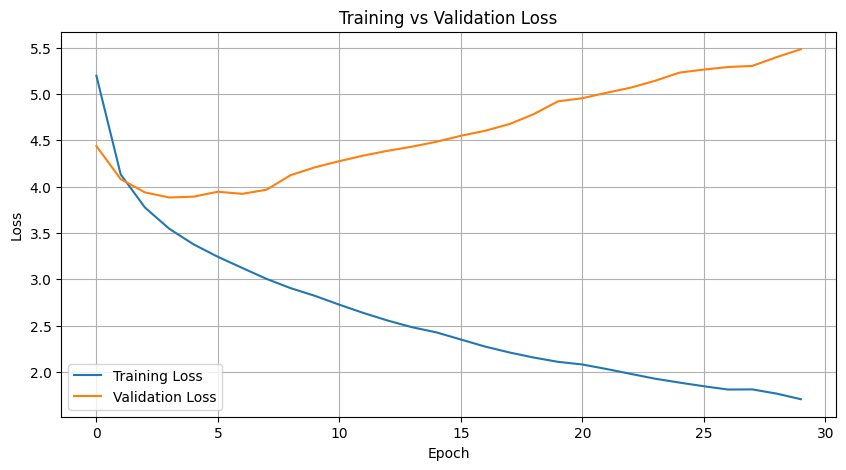

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Caption generation
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += " " + word
    return in_text

In [ ]:
# Evaluation metrics
def evaluate_model(model, test, mapping, features, tokenizer, max_length):
    actual = []
    predicted = []
    log_probs = []
    skipped_images = []

    print(f"Evaluating {len(test)} test images...")
    for key in tqdm(test):
        if key not in features:
            skipped_images.append(key)
            continue
        if key not in mapping:
            print(f"Warning: Image ID {key} not found in mapping.")
            continue
        captions = mapping[key]
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        actual_captions = [caption.split() for caption in captions]
        y_pred_words = y_pred.split()
        actual.append(actual_captions)
        predicted.append(y_pred_words)

        # Calculate log probability for perplexity
        sequence = tokenizer.texts_to_sequences([y_pred])[0]
        log_prob = 0
        for i in range(len(sequence) - 1):
            # Use sequence up to position i to predict token at position i+1
            input_seq = sequence[:i+1]
            target_token = sequence[i+1]
            seq_padded = pad_sequences([input_seq], maxlen=max_length)
            probs = model.predict([features[key], seq_padded], verbose=0)  # Shape: (1, vocab_size)
            prob = probs[0, target_token]  # Probability of the target token
            if prob > 0:  # Avoid log(0)
                log_prob += np.log(prob)

        log_probs.append(log_prob)

    if skipped_images:
        print(f"Skipped {len(skipped_images)} images not found in features: {skipped_images[:5]}...")
    if not actual or not predicted:
        raise ValueError("No valid captions generated for evaluation. Check test set and features.")

    # Return actual and predicted captions
    return actual, predicted # Added return statement

In [ ]:
actual, predicted = evaluate_model(model, test, mapping, features, tokenizer, max_length)

# BLEU Scores
bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

NameError: name 'evaluate_model' is not defined

In [ ]:
 # METEOR Score
meteor_scores = [np.mean([meteor_score([ref], pred) for ref in act]) for act, pred in zip(actual, predicted)]
meteor_avg = np.mean(meteor_scores)


In [ ]:
# ROUGE-L Score
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [np.mean([scorer.score(' '.join(ref), ' '.join(pred))['rougeL'].fmeasure for ref in act]) for act, pred in zip(actual, predicted)]
rouge_l_avg = np.mean(rouge_scores)

In [ ]:
!pip install cider # Install the cider package

  Using cached cider-1.1.12.tar.gz (24 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Install pycocoevalcap and set up cider
!pip install pycocoevalcap  # This may not work directly; proceed to manual setup if it fails
!git clone https://github.com/salaniz/pycocoevalcap.git
import sys
import os

# Check if cider directory exists and add to path
if os.path.exists('/content/pycocoevalcap/cider'):
    sys.path.append('/content/pycocoevalcap')
else:
    raise FileNotFoundError("CIDEr directory not found. Ensure the repository was cloned successfully.")

# Verify the cider module can be imported
try:
    from cider.cider import Cider
    print("CIDEr module imported successfully.")
except ImportError as e:
    print(f"Failed to import Cider: {e}")
    raise


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 26.1 MB/s eta 0:00:00
Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 821 (delta 4), reused 3 (delta 3), pack-reused 809 (from 2)
Receiving objects: 100% (821/821), 130.06 MiB | 31.04 MiB/s, done.
Resolving deltas: 100% (424/424), done.
CIDEr module imported successfully.


In [ ]:
   # CIDEr Score
from cider.cider import Cider # Import the Cider class
cider_scorer = Cider()
actual_cider = {i: [' '.join(c) for c in caps] for i, caps in enumerate(actual)}
predicted_cider = {i: [' '.join(p)] for i, p in enumerate(predicted)}
cider_score, _ = cider_scorer.compute_score(actual_cider, predicted_cider)

In [ ]:
# Word-level Accuracy
def word_accuracy(actual, predicted):
    correct_words = 0
    total_words = 0
    for act_caps, pred_cap in zip(actual, predicted):
        for act_cap in act_caps:
            act_words = [word for word in act_cap if word not in ['startseq', 'endseq']]
            pred_words = [word for word in pred_cap if word not in ['startseq', 'endseq']]
            min_len = min(len(act_words), len(pred_words))
            correct_words += sum(1 for i in range(min_len) if act_words[i] == pred_words[i])
            total_words += len(act_words)
    return correct_words / total_words if total_words > 0 else 0
word_acc = word_accuracy(actual, predicted)

In [ ]:
    # Metrics Table
metrics = {
'BLEU-1': bleu_1,
'BLEU-2': bleu_2,
'BLEU-3': bleu_3,
'BLEU-4': bleu_4,
'METEOR': meteor_avg,
'ROUGE-L': rouge_l_avg,
'CIDEr': cider_score,
'Word Accuracy': word_acc,
}
metrics_df = pd.DataFrame([metrics])
print("\nEvaluation Metrics:")
print(metrics_df)



Evaluation Metrics:
     BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L     CIDEr  \
0  0.454458  0.199821  0.095696  0.041299  0.146983  0.227503  0.099939   

   Word Accuracy  
0       0.035686  


In [ ]:
# Run evaluation
metrics = evaluate_model(model, test, mapping, features, tokenizer, max_length)

Evaluating 810 test images...


  0%|          | 0/810 [00:00<?, ?it/s]

Actual Captions: ['startseq people are riding around on snowmobiles endseq', 'startseq people pose with helmets and goggles on while riding snowmobiles endseq', 'startseq several people are taking break while on snowmobiling ride endseq', 'startseq three people and two snowmobiles endseq', 'startseq two helmeted men sit on yellow snowmobiles while another man stands behind watching endseq']
Predicted Caption: startseq man in blue shirt and jeans is running on sidewalk with several other people behind him


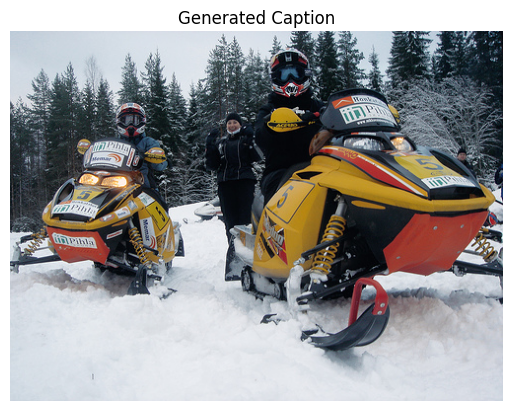

In [ ]:
# Visualize a sample caption
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Actual Captions:', captions)
    print('Predicted Caption:', y_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Generated Caption')
    plt.show()

generate_caption('109738916_236dc456ac.jpg')

Actual Captions: ['startseq black and white dog is catching frisbee endseq', 'startseq black and white dog is catching frisbee endseq', 'startseq dog catching frisbee endseq', 'startseq white dog with black spots catches bright green and pink frisbee in field endseq', 'startseq the dog jumps to catch flying disc endseq']
Predicted Caption: startseq two dogs run across field


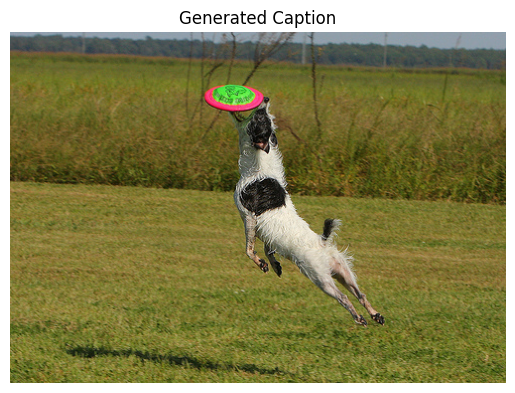

In [ ]:
generate_caption('2896483502_6f807bae9e.jpg')

Actual Captions: ['startseq boy is doing skateboarding trick in the air endseq', 'startseq boy jumps high above his skateboard near sign endseq', 'startseq boy jumping skateboard beside sign and pink flowers endseq', 'startseq he is skateboarding endseq', 'startseq the boy in black is skateboarding in the air in front of the flowers and white and blue sign endseq']
Predicted Caption: startseq man in red shirt and jeans is standing in stadium with large brown dog


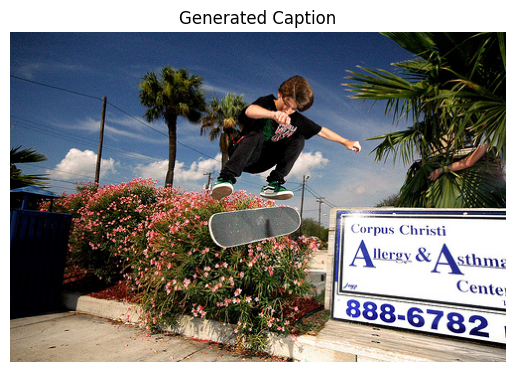

In [ ]:
generate_caption('3597146852_3d000a5d5f.jpg')